In [7]:
import os, psutil, gc
import time 
import json
import pprint
import signal

import re

from collections import defaultdict
import random

import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("ticks")
sns.set_palette("tab20")
colors = sns.color_palette("bright")

import warnings

In [2]:
import torch 
from transformers import AutoModelForCausalLM, AutoTokenizer
from vllm import LLM, SamplingParams, PoolingParams

from sal.config import Config
from sal.models.reward_models import PRM
from sal.utils.score import aggregate_scores

from core.reward_models import RLHFFlow

from datasets import Dataset, load_dataset

from core import best_of_n
from utils.load_data import load_data_prm800k
from utils import grader 
from utils import grader2
from utils import parser

In [3]:
# base_dir
base_dir = '/groups/kjun/tnn/datasets/'

# dataset path
# data_dir = base_dir + "/prm800k/math_splits"
data_dir = base_dir + "/math500"

# llm and prm path
llm_dir = base_dir + "/Llama-3.2-1B-Instruct-GGUF/Llama-3.2-1B-Instruct.Q4_K_M.gguf"
prm_dir = base_dir + "/Llama3.1-8B-PRM-Deepseek-Data-GGUF/Llama3.1-8B-PRM-Deepseek-Data.Q4_K_M.gguf"

llm_tokenizer_dir = base_dir + "/Llama-3.2-1B-Instruct"
prm_tokenizer_dir = base_dir + "/Llama3.1-8B-PRM-Deepseek-Data"

In [4]:
dataset_name = "HuggingFaceH4/Llama-3.2-1B-Instruct-best-of-N-completions"
dataset_name = "HuggingFaceH4/Llama-3.2-1B-Instruct-beam-search-completions"
dataset_split = 'train'
# config_name = "HuggingFaceH4_MATH-500--T-0.8--top_p-1.0--n-256--max_tokens-2048--bsz-8--seed-0--agg_strategy-last" 
config_name = "HuggingFaceH4_MATH-500--T-0.8--top_p-1.0--n-256--max_tokens-2048--bsz-8--seed-0--agg_strategy-last"
config_name = "HuggingFaceH4_MATH-500--T-0.8--top_p-1.0--n-256--m-4--iters-40--look-0--seed-0--agg_strategy-last"

dataset = load_dataset(dataset_name, name=config_name, split=dataset_split, cache_dir=data_dir)

README.md:   0%|          | 0.00/45.1k [00:00<?, ?B/s]

In [5]:
def split_steps(text):
    # Find all start positions of steps
    step_starts = [match.start() for match in re.finditer(r'## Step \d+:', text)]
    step_starts.append(len(text))  # Add end of text as final boundary

    steps = []
    for i in range(len(step_starts) - 1):
        chunk = text[step_starts[i]:step_starts[i+1]]
        steps.append(chunk.strip())

    # Extend the last step to include final answer if present
    if steps and r'\boxed' in text:
        # Append the last boxed line to the final step if not already included
        final_answer_match = re.search(r'The final answer is:.*?\\boxed\{.*?\}', text)
        if final_answer_match:
            final_answer = final_answer_match.group(0).strip()
            if final_answer not in steps[-1]:
                steps[-1] += '\n\n' + final_answer

    return steps

# def split_steps(text):
#     # Find all step headers and their positions
#     step_matches = list(re.finditer(r"## Step \d+", text))
#     step_positions = [(m.start(), m.group(0)) for m in step_matches]

#     steps = []

#     # Extract each step block based on positions
#     for i in range(len(step_positions)):
#         start_idx = step_positions[i][0]
#         end_idx = step_positions[i + 1][0] if i + 1 < len(step_positions) else len(text)
#         # step_text = text[start_idx:end_idx]
#         step_text = text[start_idx:end_idx].strip()
#         steps.append(step_text)

#     if len(steps) == 0:
#         return steps 

#     steps_adjusted = steps[:-1]
#     newlines = "\n\n"
#     # print(text)
#     # print(steps)
#     last_step = steps[-1].split(newlines)
#     tmp_step = newlines.join(last_step[:-1])
#     tmp_step = tmp_step.strip()
#     steps_adjusted.append(tmp_step)
#     steps_adjusted.append(last_step[-1])
    
#     # for step in steps_adjusted:
#     #     print(step)
#     # # print(steps)
#     # stop
#     # # Extract final answer sentence with \boxed{}
#     # final_answer_match = re.search(r"The final answer is:.*?\\boxed\{.*?\}", text)
#     # final_answer = final_answer_match.group(0).strip() if final_answer_match else None

#     return steps

level = 4
dataset_by_level = dataset.filter(lambda example: example['level'] == level)

all_nsteps_per_level = []
all_ntokens_per_level = []
for q_idx, data in enumerate(dataset_by_level):
    # pprint.pprint(data)
    # print(len(data["completion_tokens"]))
    # stop
    
    all_nsteps_per_question = [] 
    all_ntokens_per_question = data["completion_tokens"]
    for i_idx, completion in enumerate(data['completions']):
        # step_matches = re.findall(r"## Step \d+:", completion)
        # steps, final_answer = split_steps_and_boxed(completion)
        steps = split_steps(completion)
        nsteps = len(steps)
        if len(steps) > 0:
            all_nsteps_per_question.append(nsteps) 

    # print(all_nsteps_per_question)
    avg_nsteps_per_question = np.mean(all_nsteps_per_question) 
    std_nsteps_per_question = np.std(all_nsteps_per_question, ddof=1) 
    all_nsteps_per_level.append(avg_nsteps_per_question)

    avg_ntokens_per_question = np.mean(all_ntokens_per_question) 
    std_ntokens_per_question = np.std(all_ntokens_per_question, ddof=1) 
    all_ntokens_per_level.append(avg_ntokens_per_question)
    
    if q_idx % 50 == 0: 
        print(f"\n-> q_idx = {q_idx}") 
        print(f"avg_nsteps_per_question = {avg_nsteps_per_question:0.2f}")
        print(f"std_nsteps_per_question = {std_nsteps_per_question:0.2f}")
        print(f"avg_ntokens_per_question = {avg_ntokens_per_question:0.2f}")
        print(f"std_ntokens_per_question = {std_ntokens_per_question:0.2f}")
        print(f"max_steps_per_question = {max(all_nsteps_per_question)}")
        print(f"min_steps_per_question = {min(all_nsteps_per_question)}")

avg_nsteps_per_level = np.mean(all_nsteps_per_level) 
std_nsteps_per_level = np.std(all_nsteps_per_level, ddof=1) 

avg_ntokens_per_level = np.mean(all_ntokens_per_level) 
std_ntokens_per_level = np.std(all_ntokens_per_level, ddof=1) 

print(f"\n-> level = {level}")
print(f"num_questions = {len(dataset_by_level)}")
print(f"avg_nsteps_per_level = {avg_nsteps_per_level:0.2f}")
print(f"std_nsteps_per_level = {std_nsteps_per_level:0.2f}")
print(f"avg_ntokens_per_level = {avg_ntokens_per_level:0.2f}")
print(f"std_ntokens_per_level = {std_ntokens_per_level:0.2f}")


-> q_idx = 0
avg_nsteps_per_question = 4.13
std_nsteps_per_question = 0.34
avg_ntokens_per_question = 368.82
std_ntokens_per_question = 41.08
max_steps_per_question = 5
min_steps_per_question = 4

-> q_idx = 50
avg_nsteps_per_question = 4.04
std_nsteps_per_question = 0.19
avg_ntokens_per_question = 382.45
std_ntokens_per_question = 53.99
max_steps_per_question = 5
min_steps_per_question = 4

-> q_idx = 100
avg_nsteps_per_question = 3.86
std_nsteps_per_question = 0.87
avg_ntokens_per_question = 364.76
std_ntokens_per_question = 45.13
max_steps_per_question = 5
min_steps_per_question = 2

-> level = 4
num_questions = 128
avg_nsteps_per_level = 8.36
std_nsteps_per_level = 7.24
avg_ntokens_per_level = 621.60
std_ntokens_per_level = 514.28


In [5]:
class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException()

def run_with_timeout(fn_extract_answer, fn_grade, completion, gt_answer, timeout=2):
    # Set the signal handler for SIGALRM
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(timeout)  # Schedule an alarm after `timeout` seconds
    try:
        c_answer = fn_extract_answer(completion, 'math')
        result = fn_grade(c_answer, gt_answer)
    except TimeoutException:
        print(f"Timeout: {completion}")
        c_answer = None
        result = None
    finally:
        signal.alarm(0)  # Cancel alarm if function returns early
    return c_answer, result

In [78]:
level = 4
dataset_by_level = dataset.filter(lambda example: example['level'] == level)

all_correctness = []
all_scores = []
all_scores_correct = []
all_scores_incorrect = []
num_elims = 0
depth = 3
for q_idx, data in enumerate(dataset_by_level):
    # pprint.pprint(data)
    # print(len(data["scores"]))
    
    q_scores = []
    q_correctness = []
    q_scores_correct = []
    q_scores_incorrect = []

    # get the ground-truth answer 
    # gt_answer = data['answer']
    gt_cot, gt_answer  = parser.parse_ground_truth(data, 'math')
    for i_idx, (scores, completion) in enumerate(zip(data['scores'], data['completions'])):
        if depth >= len(scores):
            continue

        # extract answer from the completion 
        # c_answer = grader.extract_last_boxed_answer(completion)
        c_answer, is_correct = run_with_timeout(parser.extract_answer, grader2.math_equal, completion, gt_answer)

        q_correctness.append(is_correct)

        score = scores[-3]
        q_scores.append(score)

        if is_correct == 1:
            q_scores_correct.append(score)
        elif is_correct == 0:
            q_scores_incorrect.append(score)
            
        # c_answer = parser.extract_answer(completion, 'math')
        # # print(completion)
        # # print(c_answer)
        # with warnings.catch_warnings(record=True) as w:
        #     warnings.simplefilter("always")  # Capture all warnings, even if ignored previously

        #     # grade the answer whether it is correct or not 
        #     is_correct = grader2.math_equal(c_answer, gt_answer)

        #     # only store the prm score at the chosen depth level 
        #     score = scores[depth]
        #     q_correctness.append(is_correct)
        #     q_scores.append(score)

        #     # also split the score into correct and incorrect buckets
        #     if is_correct == 1:
        #         q_scores_correct.append(score)
        #     elif is_correct == 0:
        #         q_scores_incorrect.append(score)
                
        #     for warning in w:
        #         print(completion)
        #         print(warning)

    # print(i_idx)
    # print(len(q_scores_correct))
    # print(len(q_scores_incorrect))
    # stop

    # for each prompt, only collect the scores if the percentage of correct completions 
    # exceeds a specified threshold 0.1   
    ratio = len(q_scores_correct) /  len(data['completions'])
    # all_scores_correct += q_scores_correct
    # all_scores_incorrect += q_scores_incorrect
    # all_correctness += q_correctness
    # all_scores += q_scores
    if ratio > 0.0:
        all_scores_correct += q_scores_correct
        all_scores_incorrect += q_scores_incorrect
        all_correctness += q_correctness
        all_scores += q_scores
    else:
        num_elims += 1
        # print(ratio)
            
    if q_idx % 50 == 0:
        print(f"\n-> q_idx = {q_idx}")
        print(f"gt_answer = {gt_answer}, c_answer = {c_answer}, is_correct = {is_correct}, prm_score = {all_scores[-1]}")




-> q_idx = 0
gt_answer = 13, c_answer = 13, is_correct = True, prm_score = 1.0

-> q_idx = 50
gt_answer = \frac{11}{36}, c_answer = \frac{11}{36}, is_correct = True, prm_score = 0.99609375

-> q_idx = 100
gt_answer = 3, c_answer = 2, is_correct = False, prm_score = 0.99609375


In [80]:
def group_by_intervals(scores, correctness, intervals):
    buckets = defaultdict(list)
    # intervals = list(range(start, stop, step))
    print(len(scores))
    print(len(correctness))
    
    for idx, (score, is_correct) in enumerate(zip(scores, correctness)):
        for i in range(len(intervals) - 1):
            lower = intervals[i]
            upper = intervals[i + 1]
            if lower < score <= upper:
                label = f"({lower}, {upper}]"
                buckets[label].append(is_correct)
                break  # once assigned, skip remaining intervals

    hist_means = np.zeros(len(intervals)-1)
    hist_ucb = np.zeros(len(intervals)-1)
    hist_lcb = np.zeros(len(intervals)-1)
    hist_pos_nlen = np.zeros(len(intervals)-1)
    hist_neg_nlen = np.zeros(len(intervals)-1)
    for i in range(len(intervals) - 1):
        lower = intervals[i]
        upper = intervals[i + 1]
        label = f"({lower}, {upper}]"
        # print(buckets[label])
        pos = np.sum(buckets[label])
        neg = len(buckets[label]) - pos
        print(f"{label}: {pos} - {neg}")
        if len(buckets[label]) == 0:
            mean = ucb = lcb = 0
        else:
            mean, ucb, lcb = compute_bounds(buckets[label])
            
        hist_means[i] = mean
        hist_ucb[i] = ucb
        hist_lcb[i] = lcb 
        hist_pos_nlen[i] = pos
        hist_neg_nlen[i] = neg
    
    return buckets, hist_means, hist_ucb, hist_lcb, hist_pos_nlen, hist_neg_nlen

intervals = list(np.arange(0, 1.1, 0.1))
_, hist_means, hist_ucb, hist_lcb, hist_pos_nlen, hist_neg_nlen = group_by_intervals(all_scores, all_correctness, intervals)
print(hist_means)

23465
23465
(0.0, 0.1]: 0.0 - 0.0
(0.1, 0.2]: 0 - 4
(0.2, 0.30000000000000004]: 4 - 34
(0.30000000000000004, 0.4]: 14 - 19
(0.4, 0.5]: 55 - 48
(0.5, 0.6000000000000001]: 7 - 105
(0.6000000000000001, 0.7000000000000001]: 20 - 143
(0.7000000000000001, 0.8]: 88 - 475
(0.8, 0.9]: 459 - 1221
(0.9, 1.0]: 14779 - 5990
[0.         0.         0.10526316 0.42424242 0.53398058 0.0625
 0.12269939 0.15630551 0.27321429 0.71158939]


In [24]:
print(hist_neg_nlen)
print(hist_pos_nlen)

[ 356.  366.  673.  146.  646.  504.  571. 1178.  347. 3265.]
[  293.   611.   370.     0.   111.   573.   354.   758.  2110. 10576.]


In [49]:
def compute_bounds(arr):
    n = len(arr)
    arr_mean = np.mean(arr)
    arr_sig = np.std(arr, ddof=1)
    arr_ucb = arr_mean + 1.96*arr_sig/np.sqrt(n)
    arr_lcb = arr_mean - 1.96*arr_sig/np.sqrt(n)

    return arr_mean, arr_ucb, arr_lcb 

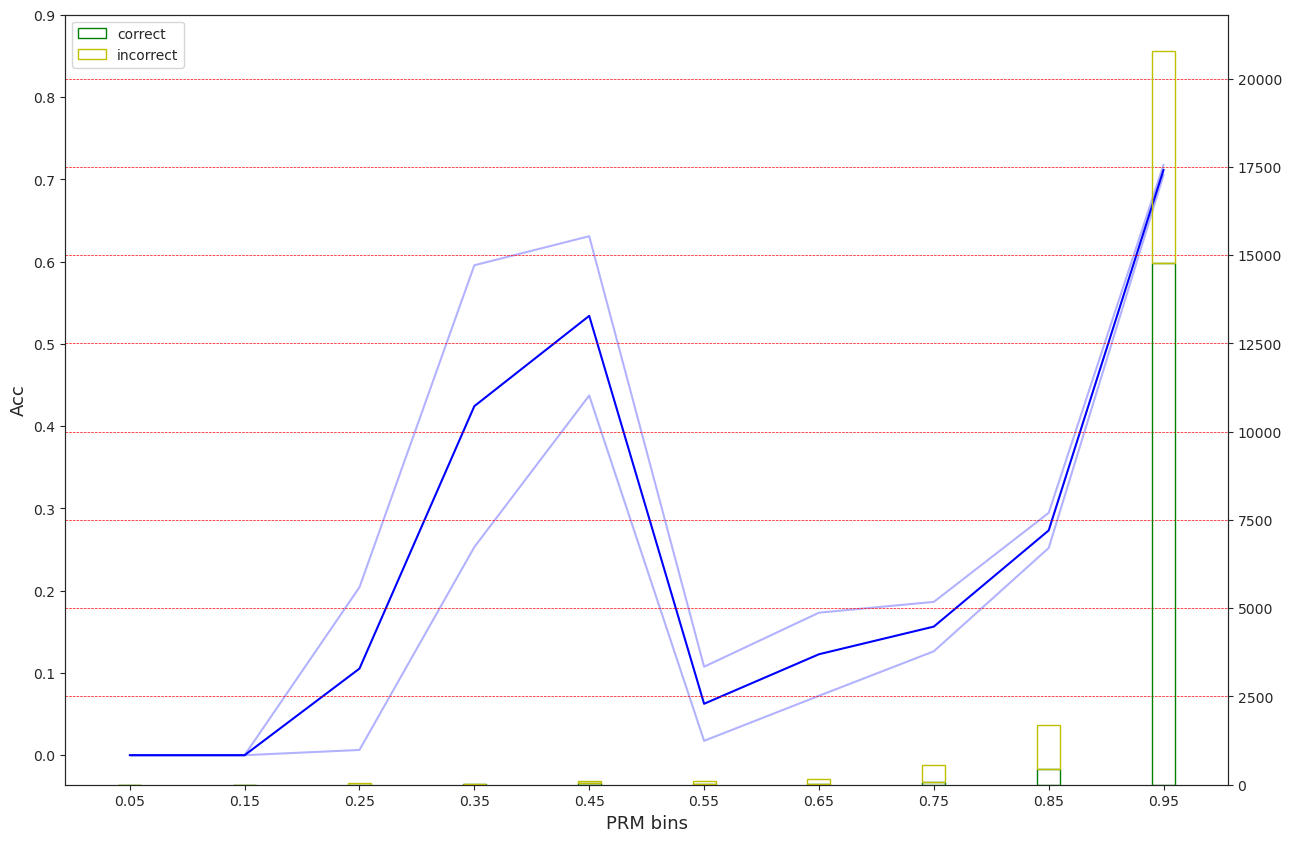

In [81]:
fig, axes = fig, axes = plt.subplots(
    nrows=1, ncols=1, sharex=False, sharey=False, figsize=(15,10))
# axes = [axes]
# axes = axes.ravel()

interval_mid_points = (np.array(intervals[1:]) + np.array(intervals[:-1]))/2

axes_opp = axes.twinx()

axes_opp.bar(
    interval_mid_points, hist_pos_nlen, width=0.02, edgecolor='g', label='correct', facecolor='none',
)


axes_opp.bar(
    interval_mid_points, hist_neg_nlen, bottom=hist_pos_nlen, width=0.02, edgecolor='y',  label='incorrect', facecolor='none',
)


axes.plot(
    interval_mid_points, hist_means, label=f"correct", color='blue',
)

axes.plot(
    interval_mid_points, hist_ucb, color='blue', alpha=0.3,
)

axes.plot(
    interval_mid_points, hist_lcb, color='blue', alpha=0.3,
)

# print(len(all_scores_correct))
# print(len(all_scores_incorrect))
# axes.legend(fontsize=12)
axes.set_xlabel('PRM bins', fontsize=13)
axes.set_xticks(interval_mid_points)
axes.set_ylabel('Acc', fontsize=13)
axes.set_yticks(np.arange(0, 1.0, 0.1))
axes_opp.legend()
plt.grid(linestyle='--', linewidth=0.5, color='r')
plt.show()

In [34]:
print(interval_mid_points)

[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]


In [15]:
print(len(all_scores_correct))
print(len(all_scores_incorrect))
hist_correct, bin_edges_correct = np.histogram(all_scores_correct, bins=10)
print(hist_correct)
print(bin_edges_correct)

15727
8043
[    2     1     0     3     2     3     5     5    16 15690]
[0.1640625  0.24765625 0.33125    0.41484375 0.4984375  0.58203125
 0.665625   0.74921875 0.8328125  0.91640625 1.        ]


In [ ]:
print(len(hist_correct))
print(len(bin_edges_correct))

In [ ]:
print(f"num elim = {num_elims} ({num_elims/len(dataset_by_level)*100:0.2f}%)")
# print(f"elim ratio = {num_elims/len(dataset_by_level):0.2}")

8043
15727
8043


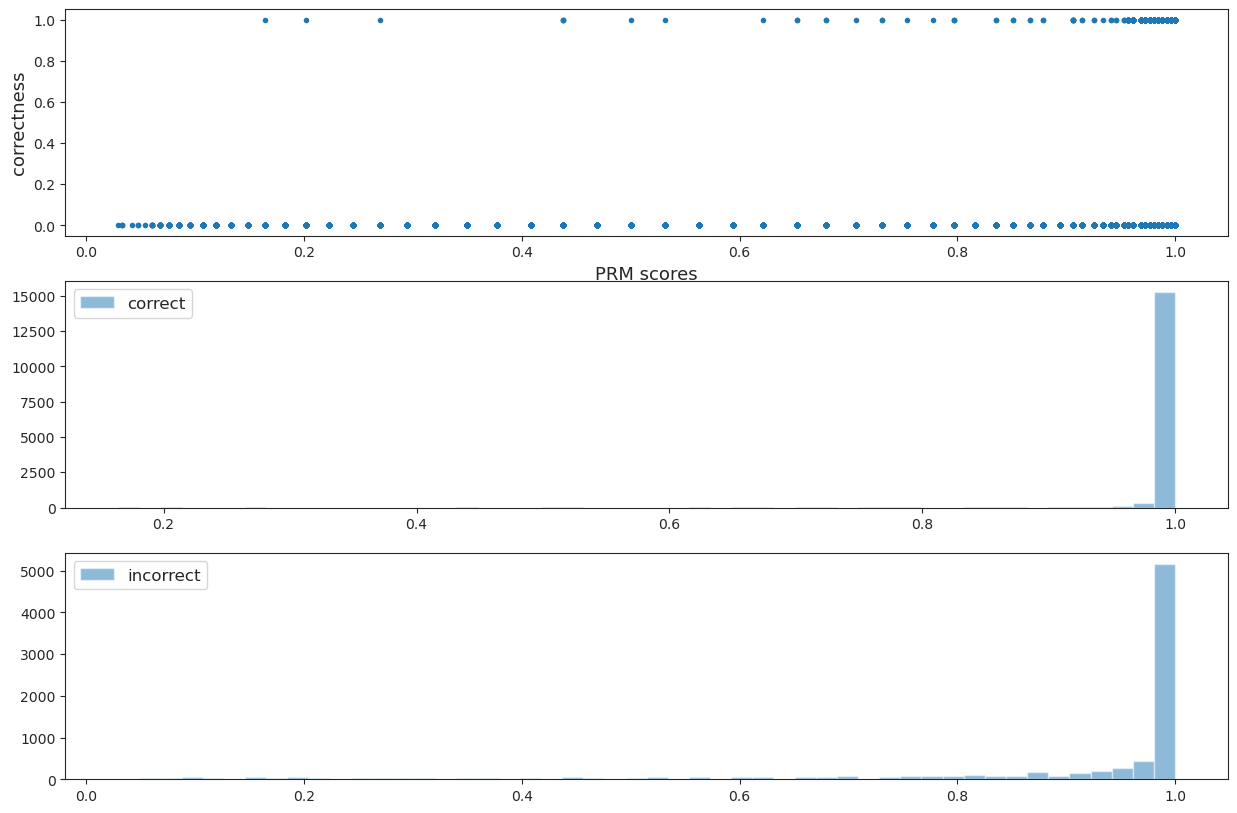

In [12]:
fig, axes = fig, axes = plt.subplots(
    nrows=3, ncols=1, sharex=False, sharey=False, figsize=(15,10))
# axes = [axes]
axes = axes.ravel()

axes[0].plot(all_scores, all_correctness, '.') 
axes[0].set_xlabel('PRM scores', fontsize=13)
axes[0].set_ylabel('correctness', fontsize=13)

# print(all_correctness[:10])
# all_scores_correct = all_scores[all_correctness == 1]
# print(all_scores_correct)
# print(len(all_scores_correct))
# stop
axes[1].hist(
    all_scores_correct, bins=50,
    label=f"correct", lw=3, alpha=0.5,  
    # color=colors[0],
    # edgecolor=colors[0],
)

print(len(all_scores_incorrect))
axes[2].hist(
    all_scores_incorrect, bins=50,
    label=f"incorrect", lw=3, alpha=0.5,  
    # color=colors[0],
    # edgecolor=colors[0],
)

print(len(all_scores_correct))
print(len(all_scores_incorrect))
axes[1].legend(fontsize=12)
axes[2].legend(fontsize=12)
plt.show()